# Read stack of dm3 image files

This notebook reads a stack of **.dm3** microscopy images for analysis.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

# this is the library for reading the dm3 files
# install this using 'pip install ncempy'
from ncempy.io import dm

# these are custom methods in a .py file in the same directory
import microscopy_methods as mm

### Identify the image stack file

In [6]:
# identify the image stack filename
stack_filename = 'stack_pure_ZrO2-24%_25%_10_pics_each_26%_after_200us_1Hz.dm3'

# get full path of the image stack file
stack_path = os.path.join(os.getcwd(), stack_filename)

### Read the file

In [8]:
# read stack data
d = mm.read_stack(stack_path)

# examine the data
for key in d:
    print('{}: {}'.format(key, d[key]))

filename: stack_pure_ZrO2-24%_25%_10_pics_each_26%_after_200us_1Hz.dm3
data: [[[1127 1197 1230 ... 1749 1662 1651]
  [ 996 1095 1164 ... 1703 1642 1661]
  [1134 1127 1158 ... 1741 1708 1618]
  ...
  [1565 1786 1770 ... 1676 1726 1721]
  [1688 1869 1777 ... 1764 1722 1838]
  [1707 1824 1660 ... 1717 1684 1750]]

 [[1136 1067 1289 ... 1691 1762 1698]
  [1096 1118 1231 ... 1725 1463 1549]
  [1193 1234 1206 ... 1656 1557 1513]
  ...
  [1491 1498 1473 ... 1570 1616 1491]
  [1534 1564 1524 ... 1711 1560 1491]
  [1711 1654 1567 ... 1658 1547 1483]]

 [[1570 1553 1651 ... 1602 1679 1633]
  [1815 1645 1679 ... 1653 1737 1750]
  [1781 1682 1705 ... 1722 1694 1741]
  ...
  [1796 1693 1608 ... 1449 1411 1465]
  [1792 1680 1564 ... 1604 1426 1316]
  [1604 1591 1493 ... 1616 1546 1515]]

 ...

 [[1377 1533 1604 ... 1407 1474 1680]
  [1309 1381 1454 ... 1410 1435 1597]
  [1273 1295 1311 ... 1567 1580 1556]
  ...
  [1425 1528 1531 ... 1689 1647 1635]
  [1512 1721 1587 ... 1538 1660 1677]
  [1642 1721 

### View some images

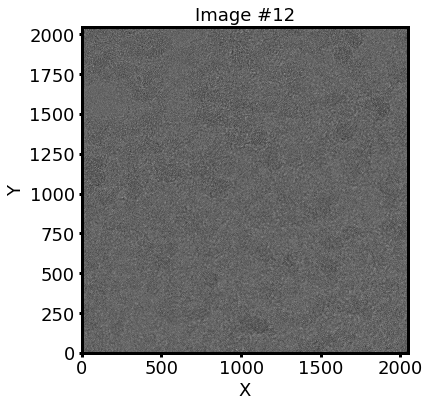

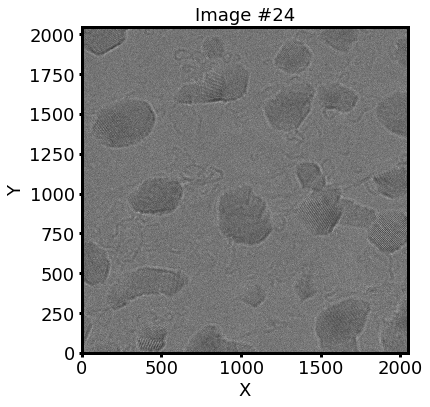

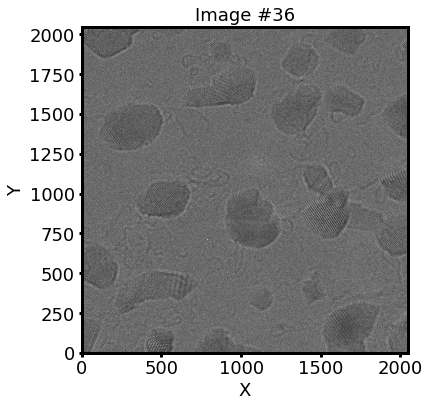

In [129]:
for i in range(12, d['data'].shape[0], 12):
    img = d['data'][i, :, :]
    img = mm.norm_image(img)

    plt.imshow(img, extent=d['span'], origin='lower', cmap='gray')
    mm.plot_setup(title='Image #{}'.format(i))
    plt.show()

In [165]:

def get_window_coords(img, samples):
    """Get a grid coordinates at which to anchor a sliding window.
    Uses 2D image data (img) and the number of samples (samples)."""
    window_anchors_x = np.arange(0, len(img[0]), samples)
    window_anchors_y = np.arange(0, len(img), samples)
    window_coords = np.array(np.meshgrid(
        window_anchors_x, window_anchors_y)).T.reshape(-1,2)
    return window_coords

def get_sampling_pixels(data, x0, y0, samp_num, oversamp_num):
    """Get pixels to sample when oversampling a 2D array.
    samp_num = number of pixels to smaple
    oversamp_num = number of pixels to oversample
    x0, y0 = origin of sampling window
    Returns pixel slices for sampling and oversampling."""
    x1, y1 = x0 + samp_num, y0 + samp_num
    over_x0, over_x1 = np.clip((
        x0-oversamp_num, x0+samp_num+oversamp_num),
            0, len(data['data'][0]))
    over_y0, over_y1 = np.clip((
        y0-oversamp_num, y0+samp_num+oversamp_num),
        0, len(data['data']))
    os_slice = np.s_[over_y0:over_y1, over_x0:over_x1]
    s_slice = np.s_[y0:y1, x0:x1]
    return s_slice, os_slice


def get_window_indices(img, samples, oversamples):
    """Get indices which describe bounds of a sliding window
    which rasters accross a 2D image.
    Two sliding windows are created:
    1. a sampling window, with 'samples' number of pixels
    2. an oversmaplign window, with 'oversamples' number of pixels
    Returns the index slices for both sliding windows."""
    
    # get list of coordinates at which to anchor each sampling window
    window_anchors_x = np.arange(0, len(img[0]), samples)
    window_anchors_y = np.arange(0, len(img), samples)
    window_coords = np.array(np.meshgrid(
        window_anchors_x, window_anchors_y)).T.reshape(-1,2)
    
    # loop over each set of coordinates for the window anchor
    for x0, y0 in window_coords:
        x1, y1 = x0 + samp_num, y0 + samp_num
        over_x0, over_x1 = np.clip((
            x0-oversamp_num, x0+samp_num+oversamp_num),
                0, len(data['data'][0]))
        over_y0, over_y1 = np.clip((
            y0-oversamp_num, y0+samp_num+oversamp_num),
            0, len(data['data']))
        os_slice = np.s_[over_y0:over_y1, over_x0:over_x1]
        s_slice = np.s_[y0:y1, x0:x1]
        return s_slice, os_slice






def map_domains(img, samples, oversamples):
    """Raster an image using a number of sampling pixels (samples),
    and a number of oversampling pixels (oversamples) which buffer
    the sampling pixels. Statistics at each sampling window are
    collected and can be overlaid on the original image."""
    '''
    # intialize empty maps to hold domain orientation information
    remap, keys = {}, ['grad_angle',
                       'grad_mag',
                       'fft_peak_dist',
                       'fft_peak_angle']
    
    
    remap = {k: np.zeros_like(data['data']).astype(float) for k in keys}
  
    '''
    
    '''
    for x0, y0 in sample_grid:
        # get sampling area, clipping if it lies outside image range
        s_slice, os_slice = get_sampling_pixels(data, x0, y0,
                                                samples, oversamples)
        # check if FFT-filtered image data exists. If not, use raw image
        if 'filtered' in list(data.keys()):
            img0 = data['filtered'][os_slice]
        else:
            img0 = data['data'][os_slice]

        # perform 2D FFT
        fft_complex = fp.fftshift(fp.fft2((img0).astype(float)))
        fft_re = np.abs(np.real(fft_complex))
        fft_im = np.abs(np.imag(fft_complex))
        # filter out center bright peak
        fft_re[int(samples/2), int(samples/2)] = 0
        indices = np.argpartition(fft_re.flatten(), -1)[-1:]
        peak_idx = np.vstack(np.unravel_index(indices, fft_re.shape)).T[0] 
        peak_loc = np.subtract(int(samples/2), [peak_idx[1], peak_idx[0]])
        fft_peak_dist = np.linalg.norm(peak_loc)
        fft_peak_angle = np.arctan(peak_loc[1]/peak_loc[0])

        # save stats of sampling window
        grad_y, grad_x = np.abs(np.gradient(img0))
        remap['grad_angle'][s_slice] = array_phase(grad_x, grad_y)
        remap['grad_mag'][s_slice] = array_mag(grad_x, grad_y)
        remap['fft_peak_dist'][s_slice] = fft_peak_dist
        remap['fft_peak_angle'][s_slice] = fft_peak_angle

    # find values with weak signal
    weak = np.where(remap['grad_mag'] < (
        np.mean(remap['grad_mag'] - np.std(remap['grad_mag']))))
    # scale final result maps
    for r in remap:
        #remap[r][weak] = np.nan
        remap[r] = scale_array(np.ma.array(
            remap[r], mask=np.isnan(remap[r])))
    '''
    return {}#remap

samples = 20



# get list of anchor coordinates for each sliding window
window_coords = get_window_coords(img, samples)



for x0, y0 in window_coords:
    # get sampling area, clipping if it lies outside image range
    s_slice, os_slice = get_sampling_pixels(data, x0, y0,
                                            samples, oversamples)


    
    
    
    
#map_domains(img, samples=20, oversamples=40)
window_coords

array([[   0,    0],
       [   0,   20],
       [   0,   40],
       ...,
       [2040, 2000],
       [2040, 2020],
       [2040, 2040]])

In [137]:
len(img[0])

2048

In [161]:
new_img.shape

(2048,)

In [92]:
blobs = blob_dog(1-img, min_sigma=100, max_sigma=300, threshold=.1)

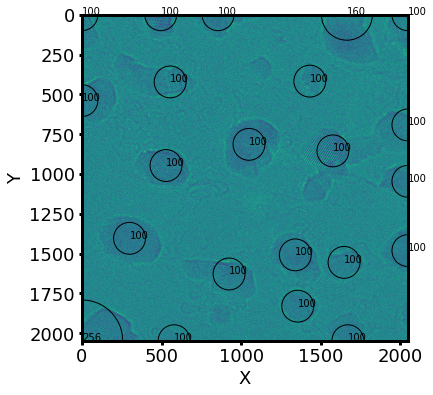

22


In [93]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.imshow(img)

for blob in blobs:
    y, x, r = blob
    
    #r *= np.sqrt(2)
    
    c = plt.Circle((x, y), r, linewidth=1, fill=False)
    ax.add_patch(c)
    plt.text(x, y, str(int(r)))

mm.plot_setup()
plt.show()

print(len(blobs))

True
8


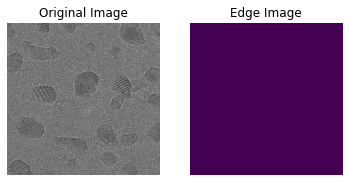

In [91]:
edges = cv2.Canny(img.astype('uint8'), 0, .01)
print(np.any(edges))
print(len(np.where(edges==255)[0]))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis(False)

plt.subplot(122)
plt.imshow(edges)#, cmap='gray')
plt.title('Edge Image')
plt.axis(False)
plt.show()

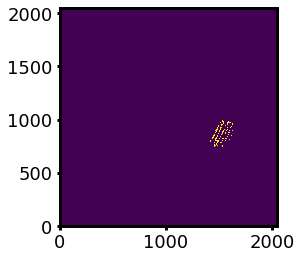

True


In [123]:
from skimage.feature import canny
canny_edges = canny(
    img,
    sigma=0.7,
    low_threshold=0.1,
    high_threshold=0.7)

plt.imshow(canny_edges, origin='lower')

plt.show()


print(np.any(canny_edges))

[]

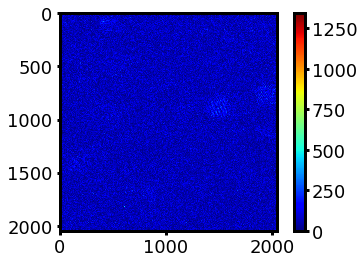

In [81]:
'''
grad_mag = np.hypot(grad_x, grad_y)

plt.imshow(grad_mag, cmap='jet')#, vmin=grad_mag.min(), vmax=grad_mag.max())
plt.colorbar()
plt.plot()
'''

In [96]:
img.shape

(2048, 2048)